In [1]:
import pyperclip
from PIL import ImageGrab,Image
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from math import ceil, floor

from bs4 import BeautifulSoup

import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh


In [48]:
# Carga archivo de coordenadas de referencias usadas para el mapeo
indice_puntos_mapeo = []
puntos_mapeo1=[]
archivo = open("mapeo_sl_facemesh.svg", "rt")
sopa = BeautifulSoup( archivo, features = 'xml')
archivo.close()
# se determina factores de escalamiento
final_width = int(sopa.svg['width'])
final_height = int(sopa.svg['height'])
final_viewBox = [float(x) for x in sopa.svg['viewBox'].split()]
escala_x = final_width / ( final_viewBox[2] - final_viewBox[0] )
escala_y = final_height / ( final_viewBox[3] - final_viewBox[1] )
for punto in sopa.svg.find('g', id= 'layer3').find_all('rect'):
    idx = punto['id'].split('_')
    if len(idx) > 1:
        indice_puntos_mapeo.append( int(idx[1]) )
        puntos_mapeo1.append({ 'x':float(punto['x']) * escala_x , 'y':float(punto['y']) * escala_y })
puntos_mapeo_df = pd.DataFrame(puntos_mapeo1, index = indice_puntos_mapeo)
puntos_mapeo_df = puntos_mapeo_df.sort_index()
puntos_mapeo_df

,x,y
0,511.745543,389.184043
1,512.245537,313.029415
2,511.995521,347.779458
5,511.917739,281.988075
6,511.899294,218.712320
...,...,...
457,541.917701,311.863075
464,583.773588,234.173313
465,566.686117,236.108768
466,673.063341,227.803736


In [3]:
areas = [
    #sobre las cejas
    [107, 9, 193, 168], [9, 336, 168, 417], [107, 221, 193], [336, 417, 441], [66, 222, 221], [336, 295, 441, 442],
    [63, 66, 224, 222], [295, 293, 442, 444], [156, 63, 113, 224], [293, 383, 444, 342], [156, 113, 143, 226],
    [342, 383, 446, 372], [143, 226, 116, 31], [446, 372, 261, 345],
    # Bajo las cejas
    [113, 247, 226, 130], [113, 224, 247, 29], [224, 222, 29, 28], [222, 221, 28, 190], [221, 190, 122], [221, 193, 122],
    [193, 168, 122, 6], [168, 417, 6, 351], [417, 441, 351], [441, 351, 414], [441, 442, 414, 258], [442, 444, 258, 259],
    [444, 342, 259, 467], [467, 342, 359, 446],
    #parpado izquierdo
    [247, 246, 130, 33], [247, 29, 246, 160], [29, 28, 160, 158], [28, 190, 158, 173], [173, 190, 133, 244], [153, 133, 22, 244],
    [144, 153, 24, 22], [7, 144, 25, 24], [130, 33, 25, 7],
    #parpado derecho
    [414, 398, 464, 362], [414, 258, 398, 385], [258, 259, 385, 387], [259, 467, 387, 466], [466, 467, 263, 359],
    [263, 249, 255, 359], [373, 249, 254, 255], [380, 373, 252, 254], [362, 380, 464, 252],
    # bajo los ojos
    [226, 130, 31, 25], [25, 24, 31, 229], [24, 22, 229, 231], [22, 244, 231, 245], [190, 122, 244, 245], [245, 231, 131],
    [245, 122, 131, 51], [122, 6, 51, 5], [6, 351, 5, 281], [351, 465, 281, 360], [351, 414, 465, 464], [465, 464, 451, 252],
    [465, 360, 451], [252, 254, 451, 449], [254, 255, 449, 261], [359, 446, 255, 261],
    # NAriz
    [131, 51, 129, 237], [129, 237, 98, 20], [20, 94, 98, 97], [94, 97, 2], [94, 2, 326], [94, 250, 326, 327],
    [457, 358, 250, 327], [281, 360, 457, 358], [51, 5, 237, 1], [5, 281, 1, 457], [237, 1, 20, 94], [1, 457, 94, 250],
    # alrededor boca
    [129, 206, 98], [358, 327, 426], [206, 212, 57], [426, 287, 432], [206, 98, 57, 39], [98, 97, 39, 37],
    [97, 2, 37, 0], [2, 326, 0, 267], [326, 327, 267, 269], [327, 426, 269, 287], [212, 57, 204, 91], [91, 181, 204, 194],
    [181, 84, 194, 201], [84, 17, 201, 200], [17, 314, 200, 421], [314, 405, 421, 418], [405, 321, 418, 424], [287, 432, 321, 424],
    # Labios
    [39, 57, 78], [269, 308, 287], [57, 91, 78], [308, 321, 287], [39, 78, 81], [269, 311, 308], [39, 37, 81, 82],
    [37, 0, 82, 13], [0, 267, 13, 312], [267, 269, 312, 311], [78, 178, 91, 181], [178, 87, 181, 84], [87, 14, 84, 17],
    [14, 317, 17, 314], [317, 402, 314, 405], [402, 308, 405, 321],
    # Cachete izquierdo
    [116, 147, 31], [31, 229, 147, 187], [229, 231, 187, 205], [231, 131, 205, 129], [129, 205, 206], [147, 214, 187],
    [187, 205, 214, 212], [205, 212, 206],
    # Cachete derecho
    [261, 376, 345], [449, 261, 411, 376], [451, 449, 425, 411], [360, 451, 358, 425], [358, 426, 425], [426, 432, 425],
    [425, 411, 432, 434], [411, 434, 376],
    # Menton
    [214, 212, 211, 204], [211, 204, 32, 194], [194, 201, 32, 208], [201, 200, 208, 199], [200, 421, 199, 428],
    [421, 418, 428, 262], [418, 424, 262, 431], [432, 434, 424, 431],
]

In [4]:
# valida que las areas referencien todos los puntos recolectados
todos_puntos = list(set([ a for b in areas for a in b]))
puntos_faltantes = [a for a in todos_puntos if a not in puntos_mapeo_df.index]
if len(puntos_faltantes) == 0:
    print('Diagramación es consistente')
else:
    print('validar los siguientes puntos: {0}'.format(str(puntos_faltantes)))
    areas_problema = [ area for area in areas for punto in puntos_faltantes if punto in area ]
    print("\n".join([str(area) for area in areas_problema] ))

Diagramación es consistente


In [5]:
def imagen_portapapeles():
    
    try:
        # Intentar abrir el contenido como una imagen
        image = ImageGrab.grabclipboard()
        
        # Convertir la imagen a formato OpenCV (cv2)
        image_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        
        return image_cv2
    
    except :
        # El contenido no es una imagen
        return None
    
def mostrar_imagen(imagen):
    # Convertir la imagen de BGR a RGB
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen utilizando matplotlib
    plt.imshow(imagen_rgb)
    plt.axis('off')
    plt.show()
    


# Aquí comienza la acción
Capturar con el portapapeles una imagen con un rostro antes de ejecutar el siguiente paso

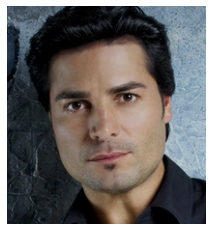

In [56]:
#Ejecutar teniendo imagen en el portapapeles

imagen = imagen_portapapeles()
if imagen is None:
    print('No hay imagen en el portapapeles')
else:
    mostrar_imagen(imagen)

In [57]:
# Extraelas marcas
results = None
with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
print(results)

<class 'mediapipe.python.solution_base.SolutionOutputs'>


Marcando marcas #0


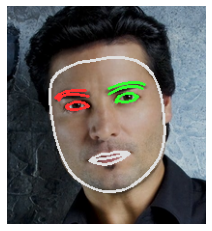

In [58]:
# Aplica marcas sobre copia 
annotated_image = np.copy(imagen)
face_landmarks_list = results.multi_face_landmarks
for idx in range(len(face_landmarks_list)):
    print('Marcando marcas #{0}'.format(idx))
    face_landmarks = face_landmarks_list[idx]
    
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    
mostrar_imagen(annotated_image)

In [59]:
# Transforma las landmarks en un Dataframe
idx_marcas = 0
face_landmarks = face_landmarks_list[idx_marcas]
ancho = imagen.shape[1]
alto = imagen.shape[0]
puntos_landmarks = [ (idx,x.x,x.y) for idx,x in enumerate(face_landmarks.landmark) ]
landmarks_df = pd.DataFrame( [{'x':q[1] * ancho, 'y':q[2] * alto } for q in puntos_landmarks] , index = [q[0] for q in puntos_landmarks] )
landmarks_df

,x,y
0,105.175650,153.634525
1,99.713804,134.967680
2,101.128932,139.131484
3,93.479189,116.980146
4,98.803895,129.518815
...,...,...
473,124.712737,94.360029
474,129.827063,93.628950
475,123.847234,89.785686
476,119.608222,95.045766


In [60]:
# Realiza cruce de dataframes para tener mapeo de coordenadas
cruce_df = puntos_mapeo_df.join(landmarks_df, how='left', lsuffix='_destino', rsuffix='_origen')
cruce_df

,x_destino,y_destino,x_origen,y_origen
0,511.745543,389.184043,105.175650,153.634525
1,512.245537,313.029415,99.713804,134.967680
2,511.995521,347.779458,101.128932,139.131484
5,511.917739,281.988075,97.962992,121.989315
6,511.899294,218.712320,96.368793,103.561399
...,...,...,...,...
457,541.917701,311.863075,107.666281,132.522972
464,583.773588,234.173313,108.227915,101.857900
465,566.686117,236.108768,106.479387,103.633696
466,673.063341,227.803736,133.899001,92.986036


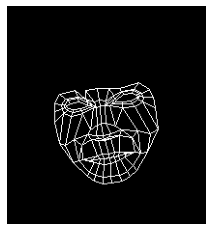

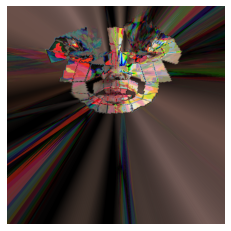

True

In [61]:
#cruce_df.loc[466,'x_destino']
malla_inicial = np.zeros( imagen.shape, dtype=np.uint8 )
malla_final = np.zeros( (final_height, final_width, 3), dtype=np.uint8 )
for indice in range(0, len(areas)):
    area = areas[indice]
    imagen_mascara = np.zeros( imagen.shape, dtype=np.uint8 )

    pol1 = [ 
        (cruce_df.loc[ area[0] ,'x_origen'], cruce_df.loc[area[0] ,'y_origen']),
        (cruce_df.loc[ area[1] ,'x_origen'], cruce_df.loc[area[1] ,'y_origen'])
    ]
    pol2 = [ 
        (cruce_df.loc[ area[0] ,'x_destino'], cruce_df.loc[area[0] ,'y_destino']),
        (cruce_df.loc[ area[1] ,'x_destino'], cruce_df.loc[area[1] ,'y_destino'])
    ]
    if len(area) >= 4:
        pol1.append( (cruce_df.loc[ area[3] ,'x_origen'], cruce_df.loc[area[3] ,'y_origen']) )
        pol2.append( (cruce_df.loc[ area[3] ,'x_destino'], cruce_df.loc[area[3] ,'y_destino']) )
    pol1.append( (cruce_df.loc[ area[2] ,'x_origen'], cruce_df.loc[area[2] ,'y_origen']) )
    pol2.append( (cruce_df.loc[ area[2] ,'x_destino'], cruce_df.loc[area[2] ,'y_destino']) )
    
    pol1_int = np.array(pol1, dtype=np.int32)
    pol2_int = np.array(pol2, dtype=np.int32)
    pol1_float = np.array(pol1, dtype=np.float32)
    pol2_float = np.array(pol2, dtype=np.float32)
    
    cv2.fillPoly( imagen_mascara, pts=[pol1_int], color=(255,255,255) )
    cv2.polylines( malla_inicial, [pol1_int], True, (255,255,255), 1 )
    #cv2.polylines( malla_final, [pol2_int], True, (255,255,255), 1 )
    
    imagen_mascara = cv2.bitwise_and(imagen_mascara, imagen)
    
    # mostrar_imagen(imagen_mascara)
    
    if len(area) < 4:
        continue
    
    try:
        matriz_transformacion = cv2.getPerspectiveTransform(pol1_float, pol2_float)
        recorte = cv2.warpPerspective(imagen_mascara, matriz_transformacion, (final_width , final_height) )
        malla_final = cv2.bitwise_xor(malla_final, recorte)
    except Exception as ex:
        print("Error \n{1}\n{2}\n{0}\n".format(str(ex), str(pol1), str(pol2) ))
mostrar_imagen(malla_inicial)
mostrar_imagen(malla_final)
cv2.imwrite("salida.png", malla_final)